In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import optuna
import seaborn as sns

d:\OneDrive - Hemas Holdings\Desktop\Model\ENV\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# PP

### DataSet

In [3]:
Data = pd.read_excel("Company Data.xlsx")
Data.to_csv("Company Data.csv", index=False)

In [4]:
Data = pd.read_csv("Company Data.csv")
Data.head()

,Month,Year,Month_Number,ItemCode,Secondary_Sales_Qty,Free_Qty,Primary_Sales_Qty,Available_Primary_Inventory_Qty,Blocked_Stock_Qty,Inspection_Stock_Qty,Total_Primary_Inventory_Qty,Distributor_Inventory_Qty,Bonus_Flag,Supply_Constraint_Flag,Distributor_Buffer_Flag,Time_Index
0,2021-03,2021,3,600153,25.0,0.0,25.0,27.0,0.0,0.0,27.0,0,0,0,0,202103
1,2021-03,2021,3,600172,7.0,0.0,7.0,1.0,0.0,0.0,1.0,0,0,0,0,202103
2,2021-03,2021,3,600232,2.0,0.0,2.0,9.0,0.0,0.0,9.0,0,0,0,0,202103
3,2021-03,2021,3,600234,11.0,0.0,11.0,70.0,0.0,0.0,70.0,0,0,0,0,202103
4,2021-03,2021,3,600235,29.0,0.0,29.0,33.0,0.0,0.0,33.0,0,0,0,0,202103


In [5]:
Data.info()

<class 'pandas.DataFrame'>
RangeIndex: 149940 entries, 0 to 149939
Data columns (total 16 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Month                            149940 non-null  str    
 1   Year                             149940 non-null  int64  
 2   Month_Number                     149940 non-null  int64  
 3   ItemCode                         149940 non-null  int64  
 4   Secondary_Sales_Qty              149940 non-null  float64
 5   Free_Qty                         149940 non-null  float64
 6   Primary_Sales_Qty                149940 non-null  float64
 7   Available_Primary_Inventory_Qty  149940 non-null  float64
 8   Blocked_Stock_Qty                149940 non-null  float64
 9   Inspection_Stock_Qty             149940 non-null  float64
 10  Total_Primary_Inventory_Qty      149940 non-null  float64
 11  Distributor_Inventory_Qty        149940 non-null  int64  
 12  Bonus_Flag   

In [6]:
Data.count()

Month                              149940
Year                               149940
Month_Number                       149940
ItemCode                           149940
Secondary_Sales_Qty                149940
Free_Qty                           149940
Primary_Sales_Qty                  149940
Available_Primary_Inventory_Qty    149940
Blocked_Stock_Qty                  149940
Inspection_Stock_Qty               149940
Total_Primary_Inventory_Qty        149940
Distributor_Inventory_Qty          149940
Bonus_Flag                         149940
Supply_Constraint_Flag             149940
Distributor_Buffer_Flag            149940
Time_Index                         149940
dtype: int64

In [7]:
# Check Duplicates
dup_count = Data.duplicated().sum()
print(dup_count)

0


In [8]:
# Check Nulls
null_count = Data.isnull().sum()
print("Nulls:\n", null_count)

Nulls:
 Month                              0
Year                               0
Month_Number                       0
ItemCode                           0
Secondary_Sales_Qty                0
Free_Qty                           0
Primary_Sales_Qty                  0
Available_Primary_Inventory_Qty    0
Blocked_Stock_Qty                  0
Inspection_Stock_Qty               0
Total_Primary_Inventory_Qty        0
Distributor_Inventory_Qty          0
Bonus_Flag                         0
Supply_Constraint_Flag             0
Distributor_Buffer_Flag            0
Time_Index                         0
dtype: int64


In [9]:
Data = Data.sort_values(["ItemCode", "Year", "Month_Number"])

### Demand Signal Engineering

In [10]:
# Start with base demand
Data["Effective_Demand"] = Data["Secondary_Sales_Qty"].clip(lower=0)

In [11]:
# Supply constraint adjustment (override)

# Rolling 3 month average 
Data["Rolling3M_SecSales"] = (Data.groupby("ItemCode")["Secondary_Sales_Qty"].transform(lambda x: x.rolling(3, min_periods=1).mean().shift(1)))

Data["Effective_Demand"] = np.where(
    Data["Supply_Constraint_Flag"] == 1,
    np.minimum(Data["Effective_Demand"], Data["Rolling3M_SecSales"].fillna(Data["Effective_Demand"])),
    Data["Effective_Demand"]
)

### Demand Cleansing layer

In [12]:
# Rolling Base trend
Data["Rolling3M_Avg"] = (
    Data.groupby("ItemCode")["Effective_Demand"]
        .transform(lambda x: x.rolling(3, min_periods=1).mean().shift(1))
)

# Rolling STD
Data["Rolling3M_Std_Eff"] = (
    Data.groupby("ItemCode")["Effective_Demand"]
        .transform(lambda x: x.rolling(3, min_periods=1).std().shift(1))
).fillna(0)

# Bonus intensity - Z-score spike detection
Data["Z_Score"] = ((Data["Effective_Demand"] - Data["Rolling3M_Avg"]) / (Data["Rolling3M_Std_Eff"] + 1))

# Future demand drop validation - Forward validation drop
Data["Next_Month_Drop"] = (
    Data.groupby("ItemCode")["Effective_Demand"].shift(-1) < 0.7 * Data["Effective_Demand"]
).fillna(False)

In [13]:
# Raw Demand
Data["Clean_Demand"] = Data["Effective_Demand"]

In [14]:
# Bonus spike smoothing
bonus_spike_condition = (
    (Data["Bonus_Flag"] == 1) &
    (Data["Z_Score"] > 2) & 
    (Data["Next_Month_Drop"])
)

Data.loc[bonus_spike_condition, "Clean_Demand"] = (
    0.7 * Data.loc[bonus_spike_condition, "Effective_Demand"] + 
    0.3 * Data.loc[bonus_spike_condition, "Rolling3M_Avg"]
)

In [15]:
# Stockout Drop Normalization
sales_drop_condition = (
    (Data["Effective_Demand"] < 0.6 * Data.groupby("ItemCode")["Effective_Demand"].shift(1)) &
    (Data["Supply_Constraint_Flag"] == 1) &
    (Data["Next_Month_Drop"])
)

Data.loc[sales_drop_condition, "Clean_Demand"] = Data["Rolling3M_Avg"]

Data["Clean_Demand"] = Data["Clean_Demand"].clip(lower=0)

In [16]:
# Shock indicators

Data["Bonus_Shock"] = bonus_spike_condition.astype(int)
Data["Supply_Shock"] = sales_drop_condition.astype(int)

### Feature Engineering 

In [17]:
# Create Target Variable
Data["Target"] = (Data.groupby("ItemCode")["Clean_Demand"].shift(-1))

In [18]:
# Lag Features
for lag in [1, 2, 3, 6, 12]:
    Data[f"Lag{lag}"] = (
        Data.groupby("ItemCode")["Clean_Demand"].shift(lag)
    )

In [19]:
# Rolling Features
Data["Rolling3M_Mean"] = (Data.groupby("ItemCode")["Clean_Demand"].transform(lambda x: x.rolling(3).mean().shift(1)))
Data["Rolling6M_Mean"] = (Data.groupby("ItemCode")["Clean_Demand"].transform(lambda x: x.rolling(6).mean().shift(1)))

# Rolling Std (Volatility)
Data["Rolling3M_Std"] = (Data.groupby("ItemCode")["Clean_Demand"].transform(lambda x: x.rolling(3).std().shift(1)))
Data["Rolling3M_Std"] = Data["Rolling3M_Std"].clip(upper=Data["Rolling3M_Std"].quantile(0.99))

In [20]:
# Momentum Feature
Data["Momentum"] = Data["Lag1"] - Data["Lag3"]

In [21]:
# Seasonality Encoding
Data["Month_Sin"] = np.sin(2 * np.pi * Data["Month_Number"]/12)
Data["Month_Cos"] = np.cos(2 * np.pi * Data["Month_Number"]/12)

In [22]:
# Inventory Pressure Feature
Data["Inventory_Pressure"] = np.where(
    Data["Lag1"] == 0,
    0,
    Data["Available_Primary_Inventory_Qty"] / (Data["Lag1"]+1)
)

Data["Inventory_Pressure"] = Data["Inventory_Pressure"].clip(upper=Data["Inventory_Pressure"].quantile(0.99))

In [23]:
# Drop NaNs
Required_cols = ["Target", "Lag1", "Lag2", "Lag3", "Lag6", "Lag12", 
                "Rolling3M_Mean", "Rolling6M_Mean", 
                "Rolling3M_Std"]

Data = Data.dropna(subset=Required_cols).copy()
Data = Data[Data["Target"] >= 0].copy()

### Data Distribution

In [24]:
Data.count()

Month                              108646
Year                               108646
Month_Number                       108646
ItemCode                           108646
Secondary_Sales_Qty                108646
Free_Qty                           108646
Primary_Sales_Qty                  108646
Available_Primary_Inventory_Qty    108646
Blocked_Stock_Qty                  108646
Inspection_Stock_Qty               108646
Total_Primary_Inventory_Qty        108646
Distributor_Inventory_Qty          108646
Bonus_Flag                         108646
Supply_Constraint_Flag             108646
Distributor_Buffer_Flag            108646
Time_Index                         108646
Effective_Demand                   108646
Rolling3M_SecSales                 108646
Rolling3M_Avg                      108646
Rolling3M_Std_Eff                  108646
Z_Score                            108646
Next_Month_Drop                    108646
Clean_Demand                       108646
Bonus_Shock                       

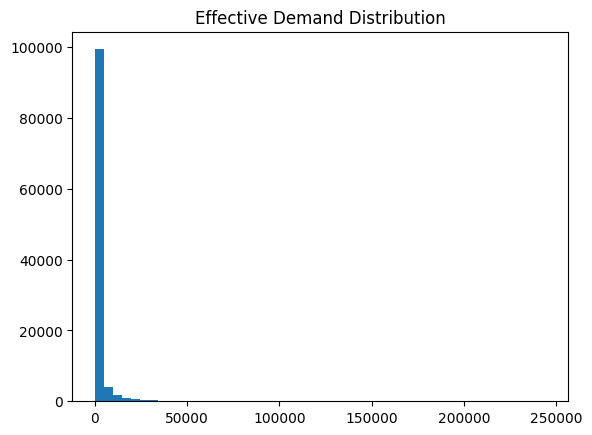

In [25]:
# Overall Distribution
plt.figure()
plt.hist(Data["Clean_Demand"], bins=50)
plt.title("Effective Demand Distribution")
plt.show()

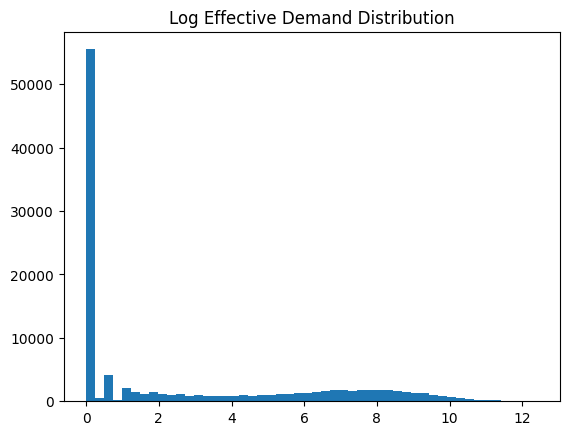

In [26]:
# Log Distribution
plt.figure()
plt.hist(np.log1p(Data["Clean_Demand"]), bins=50)
plt.title("Log Effective Demand Distribution")
plt.show()

In [27]:
print("Skewness:", Data["Clean_Demand"].skew())
print("Kurtosis:", Data["Clean_Demand"].kurt())

Skewness: 10.804018863353694
Kurtosis: 174.56533628557503


In [28]:
zero_ratio = (Data["Clean_Demand"]==0).mean()
print("Zero Demand Ratio:", zero_ratio)

Zero Demand Ratio: 0.5102810964048378


In [29]:
zero_ratio = (Data["Target"] == 0).mean()
print(zero_ratio)

0.5162454209082709


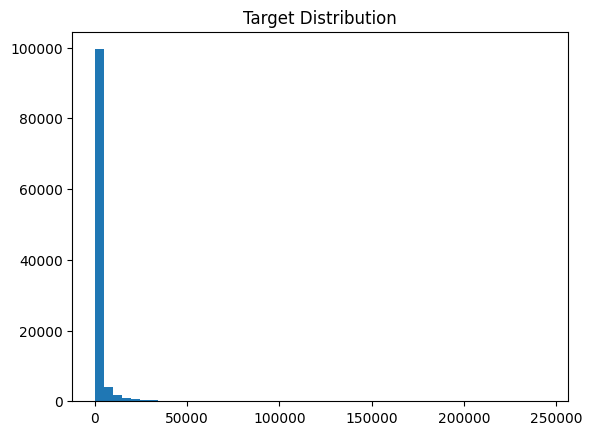

Target Skewness: 10.80438411439023


In [30]:
plt.figure()
plt.hist(Data["Target"], bins=50)
plt.title("Target Distribution")
plt.show()

print("Target Skewness:", Data["Target"].skew())

In [31]:
q99 = Data["Clean_Demand"].quantile(0.99)

print("99th percentile:", q99)
print("Max Demand:", Data["Clean_Demand"].max())

99th percentile: 33378.90000000005
Max Demand: 244345.8


In [32]:
sku_status = Data.groupby("ItemCode")["Clean_Demand"].agg(["mean", "std", "max", "min", "count"])
print(sku_status.describe())

                mean           std            max           min        count
count    2751.000000   2739.000000    2751.000000   2751.000000  2751.000000
mean     1599.275232    704.223272    3566.283548    428.539151    39.493275
std      6797.579625   2763.625856   13553.449740   2438.441650    12.127109
min         0.000000      0.000000       0.000000      0.000000     1.000000
25%         0.000000      0.000000       0.000000      0.000000    39.000000
50%         1.658915      2.457596      11.000000      0.000000    46.000000
75%       316.251773    228.624329    1097.000000      0.000000    47.000000
max    149970.380851  65102.892680  244345.800000  55150.000000    47.000000


# Modelling

### Core Config

In [33]:
TARGET_COL = "Target"

FEATURE_COLS = [
    "ItemCode", "ABC_Class",
    "Lag1","Lag2","Lag3","Lag6","Lag12",
    "Rolling3M_Mean","Rolling6M_Mean","Rolling3M_Std",
    "Momentum",
    "Month_Sin","Month_Cos",
    "Inventory_Pressure",
    "Bonus_Flag","Supply_Constraint_Flag",
    "Bonus_Shock","Supply_Shock",
    "Available_Primary_Inventory_Qty",
    "Distributor_Inventory_Qty",
    "Blocked_Stock_Qty"
]

'''Don't use Next_Month_Drop as Feature'''

"Don't use Next_Month_Drop as Feature"

### Helper Functions

##### Other

In [34]:
def sanitize(df):
    df = df.replace([np.inf, -np.inf], np.nan)
    return df.fillna(0)

def wmape(y_true, y_pred):
    denominator = np.sum(y_true)
    if denominator == 0:
        return 0
    return np.sum(np.abs(y_true - y_pred)) / denominator * 100

def forecast_bias(y_true, y_pred):
    denominator = np.sum(y_true)
    if denominator == 0:
        return 0
    return np.sum(y_pred - y_true) / denominator * 100

def evaluate_all_metrics(y_true, y_pred):
    return {
        "WMAPE": wmape(y_true, y_pred),
        "Bias": forecast_bias(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred))
    }

def recompute_target(df):
    df = df.copy()
    df[TARGET_COL] = df.groupby("ItemCode")["Clean_Demand"].shift(-1)
    return df

def rebuild_time_features(df):
    df = df.sort_values(["ItemCode", "Year", "Month_Number"]).copy()

    # Lags
    for lag in [1,2,3,6,12]:df[f"Lag{lag}"] = (df.groupby("ItemCode")["Clean_Demand"].shift(lag))

    # Rolling
    df["Rolling3M_Mean"] = (df.groupby("ItemCode")["Clean_Demand"].transform(lambda x: x.rolling(3).mean().shift(1)))
    df["Rolling6M_Mean"] = (df.groupby("ItemCode")["Clean_Demand"].transform(lambda x: x.rolling(6).mean().shift(1)))
    df["Rolling3M_Std"] = (df.groupby("ItemCode")["Clean_Demand"].transform(lambda x: x.rolling(3).std().shift(1)))
    df["Momentum"] = df["Lag1"] - df["Lag3"]

    return df

##### Fold Adjustments

In [35]:
# ItemCode Encoding
def encode_itemcode(train_df, valid_df):

    train_df = train_df.copy()
    valid_df = valid_df.copy()

    categories = train_df["ItemCode"].astype("category").cat.categories

    train_df["ItemCode"] = pd.Categorical(
        train_df["ItemCode"], categories=categories
    ).codes

    valid_df["ItemCode"] = pd.Categorical(
        valid_df["ItemCode"], categories=categories
    ).codes

    return train_df, valid_df

# SKU Cap Function
def apply_sku_cap(train_df, valid_df, quantile=0.995):
    train_df = train_df.copy()
    valid_df = valid_df.copy()

    sku_cap = (train_df.groupby("ItemCode")["Clean_Demand"].quantile(quantile))

    train_df["Clean_Demand"] = np.minimum(train_df["Clean_Demand"], train_df["ItemCode"].map(sku_cap))
    valid_df["Clean_Demand"] = np.minimum(valid_df["Clean_Demand"], valid_df["ItemCode"].map(sku_cap))

    return train_df, valid_df

# ABC Classification Function
def apply_abc_classification(train_df, valid_df):
    train_df = train_df.copy()
    valid_df = valid_df.copy()

    sku_total = (train_df.groupby("ItemCode")["Clean_Demand"].sum().sort_values(ascending=False))

    cum_pct = sku_total.cumsum() / sku_total.sum()

    abc_map = pd.cut(
        cum_pct,
        bins=[0, 0.7, 0.9, 1.0],
        labels=[0, 1, 2]
    ).to_dict()

    train_df["ABC_Class"] = train_df["ItemCode"].map(abc_map).fillna(2)
    valid_df["ABC_Class"] = valid_df["ItemCode"].map(abc_map).fillna(2)

    return train_df, valid_df

# Combined Wrapper
def apply_fold_adjustments(train_df, valid_df):
    train_df, valid_df = apply_sku_cap(train_df, valid_df)
    train_df, valid_df = apply_abc_classification(train_df, valid_df)

    return train_df, valid_df

##### Final 2025 Function

In [36]:
# Final Model Func
def train_final_and_test_2025(Data, FEATURE_COLS, TARGET_COL, best_params):

    print("\n========== FINAL MODEL → 2025 ==========")

    train_final = Data[Data["Year"] < 2025].copy()
    test_2025 = Data[Data["Year"] == 2025].copy()

    if train_final.empty or test_2025.empty:
        print("2025 data not available.")
        return None

    # Apply adjustments using train-only statistics
    train_final, test_2025 = apply_fold_adjustments(train_final, test_2025)

    combined = pd.concat([train_final, test_2025]).sort_values(["ItemCode","Year","Month_Number"])
    combined = rebuild_time_features(combined)

    train_final = combined[combined["Year"] < 2025]
    test_2025 = combined[combined["Year"] == 2025]

    # Recompute Target safely
    train_final = recompute_target(train_final)
    test_2025 = recompute_target(test_2025)

    train_final = train_final.dropna(subset=[TARGET_COL])
    test_2025 = test_2025.dropna(subset=[TARGET_COL])

    train_final, test_2025 = encode_itemcode(train_final, test_2025)

    # Train final model
    final_model = xgb.XGBRegressor(
        objective='reg:tweedie',
        eval_metric="rmse",
        random_state=42,
        early_stopping_round=None,
        **best_params
    )
    final_model.fit(
        sanitize(train_final[FEATURE_COLS]), 
        train_final[TARGET_COL],
        verbose=False
        )

    # Predict 2025
    test_2025["Pred"] = final_model.predict(sanitize(test_2025[FEATURE_COLS]))

    # WMAPE by ABC
    print("\n2025 WMAPE by ABC:")
    print(test_2025.groupby("ABC_Class").apply(lambda x: wmape(x[TARGET_COL].values, x["Pred"].values)))

    overall_wmape = wmape(test_2025[TARGET_COL].values, test_2025["Pred"].values)
    print(f"\n2025 Overall WMAPE: {overall_wmape:.4f}")

    return final_model, test_2025

### Tune

In [37]:
TUNE_YEARS = [2023, 2024]

def objective(trial):

    params = {
        "objective": "reg:tweedie",
        "eval_metric": "rmse",
        "tweedie_variance_power": trial.suggest_float("tweedie_variance_power", 1.2, 1.55),
        "n_estimators": trial.suggest_int("n_estimators", 700, 1400),
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.06),
        "max_depth": trial.suggest_int("max_depth", 4, 7),
        "max_leaves": 64,
        "grow_policy": "lossguide",
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 6),
        "subsample": trial.suggest_float("subsample", 0.75, 0.9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.75, 0.9),
        "gamma": trial.suggest_float("gamma", 0, 0.3),
        "reg_lambda": trial.suggest_float("reg_lambda", 2, 12),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 3),
        "early_stopping_rounds": 50,
        "random_state": 42
    }

    scores = []

    for year in TUNE_YEARS:

        train = Data[Data["Year"] < year].copy()
        valid = Data[Data["Year"] == year].copy()

        train, valid = apply_fold_adjustments(train, valid)

        combined = pd.concat([train, valid]).sort_values(["ItemCode","Year","Month_Number"])
        combined = rebuild_time_features(combined)

        train = combined[combined["Year"] < year]
        valid = combined[combined["Year"] == year]

        train = recompute_target(train)
        valid = recompute_target(valid)

        train = train.dropna(subset=[TARGET_COL])
        valid = valid.dropna(subset=[TARGET_COL])

        train, valid = encode_itemcode(train, valid)

        model = xgb.XGBRegressor(**params)

        model.fit(
            sanitize(train[FEATURE_COLS]),
            train[TARGET_COL],
            eval_set=[(sanitize(valid[FEATURE_COLS]), valid[TARGET_COL])],
            verbose=False
        )

        preds = model.predict(sanitize(valid[FEATURE_COLS]))
        scores.append(wmape(valid[TARGET_COL].values, preds))

    return np.mean(scores)

In [38]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40)
best_params = study.best_params
print("\nBest Params:", best_params)

[I 2026-02-25 16:03:09,643] A new study created in memory with name: no-name-0f85561a-a251-4582-bc43-8498e0d7d4c2
C:\Users\Dhanujij.pharma\AppData\Local\Temp\ipykernel_15728\3829247819.py:13: Pandas4Warning: Constructing a Categorical with a dtype and values containing non-null entries not in that dtype's categories is deprecated and will raise in a future version.
  valid_df["ItemCode"] = pd.Categorical(
C:\Users\Dhanujij.pharma\AppData\Local\Temp\ipykernel_15728\3829247819.py:13: Pandas4Warning: Constructing a Categorical with a dtype and values containing non-null entries not in that dtype's categories is deprecated and will raise in a future version.
  valid_df["ItemCode"] = pd.Categorical(
[I 2026-02-25 16:03:26,656] Trial 0 finished with value: 27.66277404909377 and parameters: {'tweedie_variance_power': 1.3442669405396244, 'n_estimators': 944, 'learning_rate': 0.020528302198820056, 'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.8323846461369698, 'colsample_bytree': 0.8131


Best Params: {'tweedie_variance_power': 1.5005784955304176, 'n_estimators': 1003, 'learning_rate': 0.023265735454458678, 'max_depth': 7, 'min_child_weight': 4, 'subsample': 0.7708120613840845, 'colsample_bytree': 0.7552349511643099, 'gamma': 0.2049574413094098, 'reg_lambda': 7.870388163487344, 'reg_alpha': 1.5678795647560644}


### Final Production Train

In [39]:
# Final Production Train (<= 2024 → Test 2025)
final_model, test_2025 = train_final_and_test_2025(Data, FEATURE_COLS, TARGET_COL, best_params)


========== FINAL MODEL → 2025 ==========


C:\Users\Dhanujij.pharma\AppData\Local\Temp\ipykernel_15728\3829247819.py:13: Pandas4Warning: Constructing a Categorical with a dtype and values containing non-null entries not in that dtype's categories is deprecated and will raise in a future version.
  valid_df["ItemCode"] = pd.Categorical(



2025 WMAPE by ABC:
ABC_Class
0.0    24.007253
1.0    27.444664
2.0    30.796989
dtype: float64

2025 Overall WMAPE: 25.3987


# Visualize

In [40]:
def plot_feature_importance(model, top_n=15):

    importance = model.get_booster().get_score(importance_type="gain")
    importance_df = (
        pd.DataFrame.from_dict(importance, orient="index", columns=["Gain"])
        .sort_values("Gain", ascending=False)
        .head(top_n)
    )

    plt.figure(figsize=(8,6))
    sns.barplot(x="Gain", y=importance_df.index, data=importance_df)
    plt.title(f"Top {top_n} Feature Importance (Gain)")
    plt.tight_layout()
    plt.show()


def plot_actual_vs_pred(y_test, preds):

    plt.figure(figsize=(6,6))
    plt.scatter(y_test, preds, alpha=0.3)

    min_val = min(y_test.min(), preds.min())
    max_val = max(y_test.max(), preds.max())

    plt.plot([min_val, max_val],
             [min_val, max_val],
             linestyle="--")

    plt.xlabel("Actual Demand")
    plt.ylabel("Predicted Demand")
    plt.title("Actual vs Predicted (2025)")
    plt.tight_layout()
    plt.show()


def plot_error_distribution(y_test, preds):

    errors = y_test - preds

    plt.figure(figsize=(7,5))
    sns.histplot(errors, bins=50, kde=True)
    plt.title("Forecast Error Distribution (2025)")
    plt.xlabel("Error (Actual - Predicted)")
    plt.tight_layout()
    plt.show()


def plot_time_series_monthly(test_df):

    df = test_df.copy()

    monthly = (
        df.groupby(["Year", "Month_Number"])
        .agg({"Target":"sum", "Pred":"sum"})
        .reset_index()
        .sort_values(["Year","Month_Number"])
    )

    plt.figure(figsize=(12,5))
    plt.plot(monthly["Target"].values, label="Actual", marker="o")
    plt.plot(monthly["Pred"].values, label="Forecast", marker="o")
    plt.legend()
    plt.title("2025 Monthly Aggregated Forecast vs Actual")
    plt.tight_layout()
    plt.show()


def plot_abc_performance(test_df):

    abc_scores = (
        test_df.groupby("ABC_Class")
        .apply(lambda x: wmape(x["Target"].values, x["Pred"].values))
        .reset_index(name="WMAPE")
    )

    plt.figure(figsize=(6,4))
    sns.barplot(data=abc_scores, x="ABC_Class", y="WMAPE")
    plt.title("2025 WMAPE by ABC Class")
    plt.tight_layout()
    plt.show()

    print(abc_scores)


def plot_top_error_skus(test_df, top_n=10):

    sku_error = (
        test_df.groupby("ItemCode")
        .apply(lambda x: wmape(x["Target"].values, x["Pred"].values))
        .reset_index(name="WMAPE")
        .sort_values("WMAPE", ascending=False)
        .head(top_n)
    )

    plt.figure(figsize=(8,6))
    sns.barplot(data=sku_error, x="WMAPE", y="ItemCode")
    plt.title(f"Top {top_n} Worst SKUs (WMAPE)")
    plt.tight_layout()
    plt.show()


def walk_forward_validation(data, feature_cols, params):

    years = [2023, 2024]
    scores = []

    for year in years:

        train = data[data["Year"] < year].copy()
        valid = data[data["Year"] == year].copy()

        train, valid = apply_fold_adjustments(train, valid)

        train = train.dropna(subset=["Target"])
        valid = valid.dropna(subset=["Target"])

        model = xgb.XGBRegressor(**params)

        model.fit(
            sanitize(train[feature_cols]),
            train["Target"],
            verbose=False
        )

        preds = model.predict(sanitize(valid[feature_cols]))
        score = wmape(valid["Target"].values, preds)

        scores.append(score)

    plt.figure(figsize=(6,4))
    plt.plot(years, scores, marker="o")
    plt.title("Walk Forward WMAPE")
    plt.ylabel("WMAPE")
    plt.xlabel("Validation Year")
    plt.tight_layout()
    plt.show()

    print("Average CV WMAPE:", np.mean(scores))

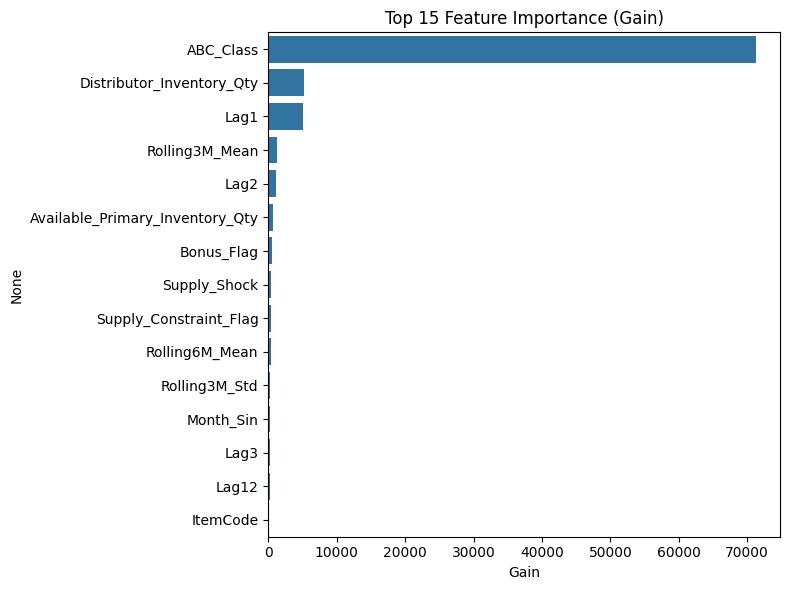

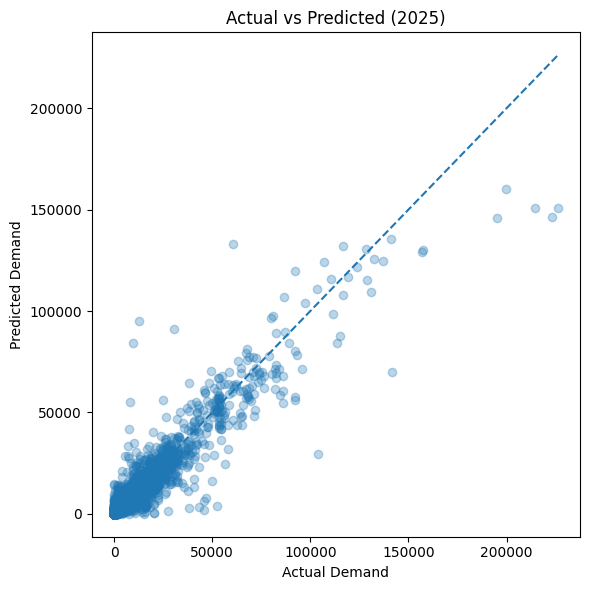

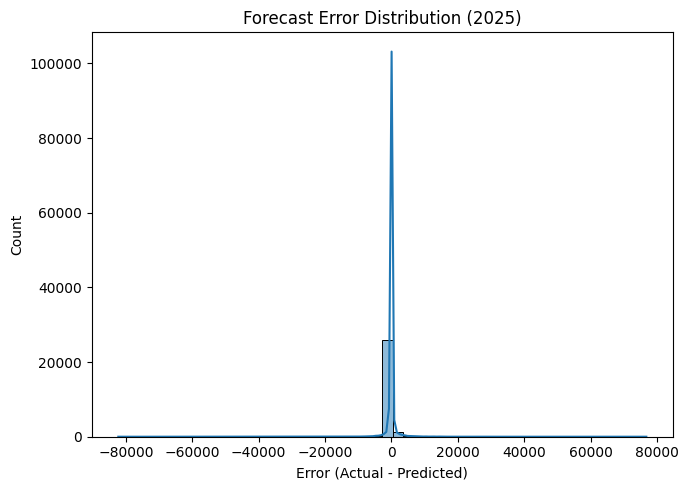

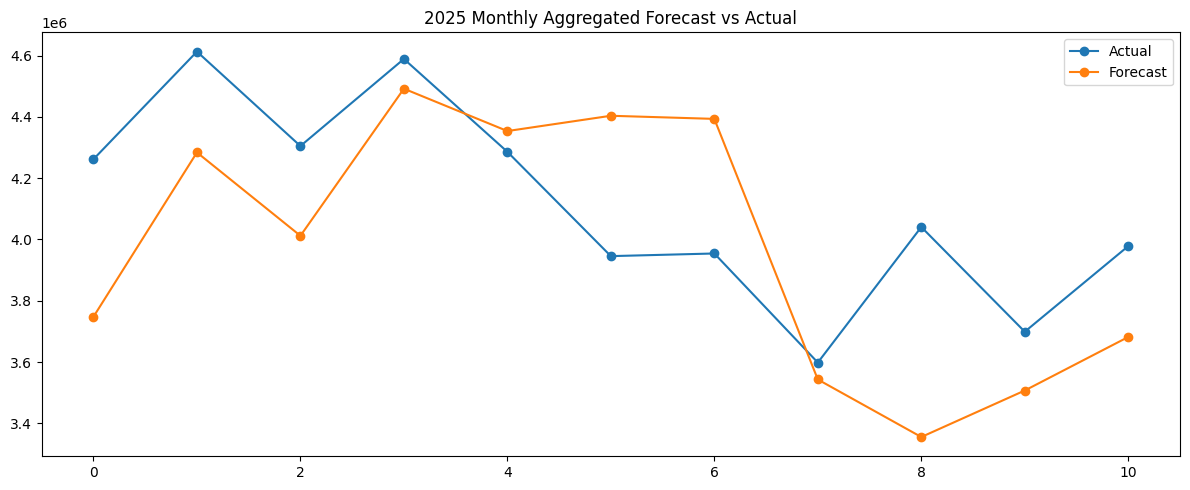

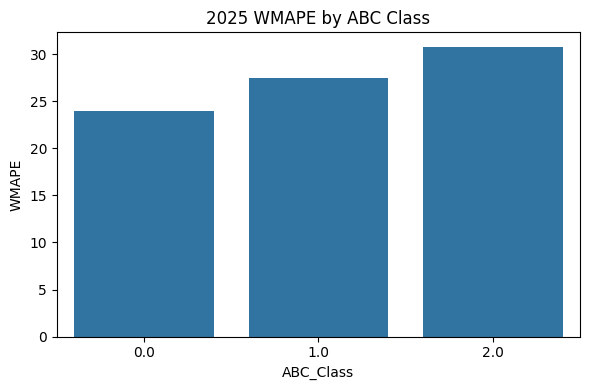

   ABC_Class      WMAPE
0        0.0  24.007253
1        1.0  27.444664
2        2.0  30.796989


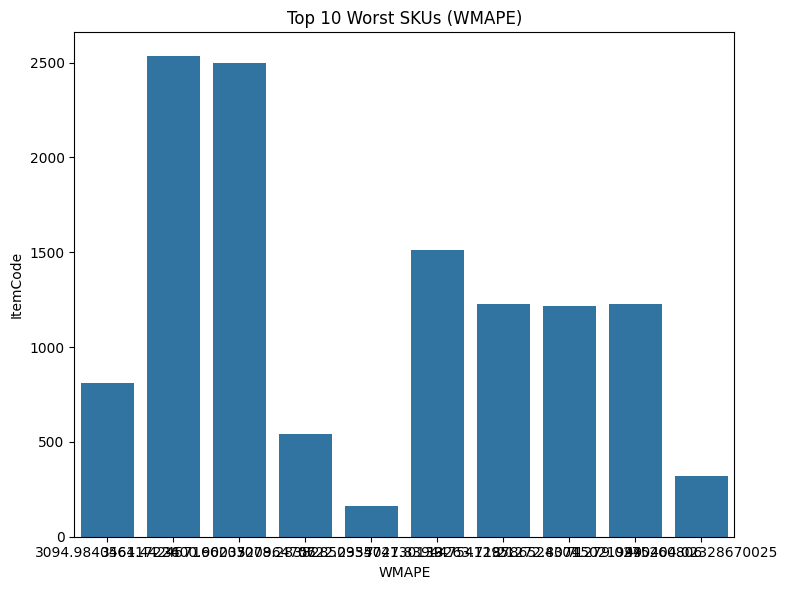

d:\OneDrive - Hemas Holdings\Desktop\Model\ENV\Lib\site-packages\xgboost\training.py:200: UserWarning: [16:36:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "tweedie_variance_power" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\OneDrive - Hemas Holdings\Desktop\Model\ENV\Lib\site-packages\xgboost\training.py:200: UserWarning: [16:36:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "tweedie_variance_power" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


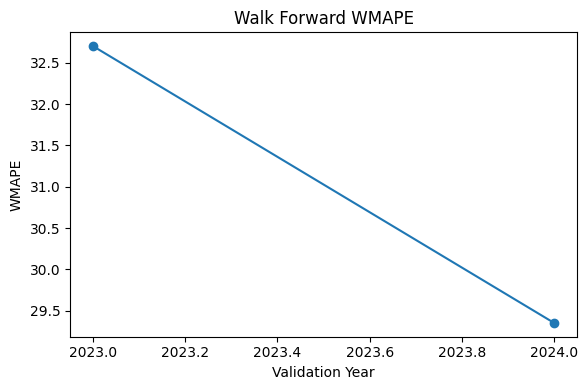

Average CV WMAPE: 31.026838655067422


In [41]:
plot_feature_importance(final_model)

plot_actual_vs_pred(test_2025["Target"], test_2025["Pred"])

plot_error_distribution(test_2025["Target"], test_2025["Pred"])

plot_time_series_monthly(test_2025)

plot_abc_performance(test_2025)

plot_top_error_skus(test_2025)

walk_forward_validation(Data, FEATURE_COLS, best_params)

In [42]:
'''
sku-forecasting/
│
├── backend/                          # Your existing FastAPI project
│   ├── app/
│   │   ├── main.py                   # FastAPI app (add CORS here)
│   │   ├── config.py
│   │   ├── schemas.py                # Add new response fields
│   │   ├── feature_engineering.py
│   │   ├── model_registry.py
│   │   └── routers/
│   │       └── predict.py            # Add /sku-history endpoint
│   ├── models/
│   │   └── forecast_model.joblib
│   └── requirements.txt
│
├── frontend/                         # New React app
│   ├── public/
│   │   └── index.html
│   ├── src/
│   │   ├── main.jsx                  # React entry point
│   │   ├── App.jsx                   # ← your sku-dashboard.jsx goes HERE
│   │   ├── api/
│   │   │   └── forecastApi.js        # ← all fetch() calls live here
│   │   └── index.css
│   ├── package.json
│   └── vite.config.js                # proxy /api → backend:8000
│
└── docker-compose.yml                # optional: run both together
'''

'\nsku-forecasting/\n│\n├── backend/                          # Your existing FastAPI project\n│   ├── app/\n│   │   ├── main.py                   # FastAPI app (add CORS here)\n│   │   ├── config.py\n│   │   ├── schemas.py                # Add new response fields\n│   │   ├── feature_engineering.py\n│   │   ├── model_registry.py\n│   │   └── routers/\n│   │       └── predict.py            # Add /sku-history endpoint\n│   ├── models/\n│   │   └── forecast_model.joblib\n│   └── requirements.txt\n│\n├── frontend/                         # New React app\n│   ├── public/\n│   │   └── index.html\n│   ├── src/\n│   │   ├── main.jsx                  # React entry point\n│   │   ├── App.jsx                   # ← your sku-dashboard.jsx goes HERE\n│   │   ├── api/\n│   │   │   └── forecastApi.js        # ← all fetch() calls live here\n│   │   └── index.css\n│   ├── package.json\n│   └── vite.config.js                # proxy /api → backend:8000\n│\n└── docker-compose.yml                # optional

# Inference

In [ ]:
def sku_inference_debug(sku_code):

    print("\n" + "="*60)
    print(f"📦 SKU INFERENCE DEBUG → {sku_code}")
    print("="*60)

    sku_df = Data[Data["ItemCode"] == sku_code].copy()
    sku_df = sku_df.sort_values(["Year", "Month_Number"])

    sku_test = test_2025[test_2025["ItemCode"] == sku_code].copy()
    sku_test = sku_test.sort_values(["Year", "Month_Number"])

    if sku_df.empty:
        print("❌ SKU not found.")
        return

    # 1️⃣ Last Month Actual
    last_month_actual = sku_df.iloc[-1]["Clean_Demand"]

    # 2️⃣ Previous Month
    if len(sku_df) > 1:
        prev_month = sku_df.iloc[-2]["Clean_Demand"]
        mom_change = ((last_month_actual - prev_month) / (prev_month + 1)) * 100
    else:
        prev_month = 0
        mom_change = 0

    # 3️⃣ Next Month Forecast
    if not sku_test.empty:
        next_month_forecast = sku_test.iloc[-1]["Pred"]
    else:
        next_month_forecast = 0

    # 4️⃣ Average Monthly Sale
    avg_monthly = sku_df["Clean_Demand"].mean()

    # 5️⃣ Bonus Events
    bonus_count = sku_df["Bonus_Flag"].sum()

    # 6️⃣ Supply Shocks
    supply_shock_count = sku_df["Supply_Shock"].sum()

    print(f"\n🔹 Last Month Actual        : {last_month_actual:,.2f}")
    print(f"🔹 Previous Month Actual    : {prev_month:,.2f}")
    print(f"🔹 MoM Change (%)           : {mom_change:,.2f}%")
    print(f"🔹 Next Month Forecast      : {next_month_forecast:,.2f}")
    print(f"🔹 Avg Monthly Sale         : {avg_monthly:,.2f}")
    print(f"🔹 Total Bonus Events       : {int(bonus_count)}")
    print(f"🔹 Total Supply Shocks      : {int(supply_shock_count)}")

    print("\n📈 Last 12 Months – Actual vs Forecast")
    if not sku_test.empty:
        display_cols = ["Year","Month_Number","Target","Pred"]
        print(sku_test[display_cols].tail(12))
    else:
        print("No forecast data available.")

    print("\n📦 Last 12 Months – Inventory")
    inv_cols = [
        "Year","Month_Number",
        "Available_Primary_Inventory_Qty",
        "Distributor_Inventory_Qty"
    ]
    print(sku_df[inv_cols].tail(12))

    print("\n🎁 Last 12 Months – Bonus & Shocks")
    shock_cols = [
        "Year","Month_Number",
        "Bonus_Flag",
        "Supply_Shock",
        "Bonus_Shock"
    ]
    print(sku_df[shock_cols].tail(12))

    print("\n" + "="*60)

In [ ]:
sku_inference_debug(600153)

In [ ]:
def recursive_next_month_forecast(sku_code, model, full_data):

    sku_df = full_data[full_data["ItemCode"] == sku_code].copy()
    sku_df = sku_df.sort_values(["Year","Month_Number"])

    if sku_df.empty:
        print("SKU not found")
        return None

    last_row = sku_df.iloc[-1:].copy()

    # ===== Create Next Month =====
    next_month = last_row["Month_Number"].values[0] + 1
    next_year = last_row["Year"].values[0]

    if next_month > 12:
        next_month = 1
        next_year += 1

    new_row = last_row.copy()
    new_row["Month_Number"] = next_month
    new_row["Year"] = next_year

    # ---- Update Lags ----
    new_row["Lag12"] = last_row["Lag11"] if "Lag11" in last_row else last_row["Lag12"]
    new_row["Lag6"]  = last_row["Lag5"] if "Lag5" in last_row else last_row["Lag6"]
    new_row["Lag3"]  = last_row["Lag2"]
    new_row["Lag2"]  = last_row["Lag1"]
    new_row["Lag1"]  = last_row["Clean_Demand"]

    # Rolling features recompute approx
    new_row["Rolling3M_Mean"] = (
        last_row[["Lag1","Lag2","Lag3"]].values.mean()
    )

    new_row["Rolling6M_Mean"] = last_row["Rolling6M_Mean"]
    new_row["Rolling3M_Std"] = last_row["Rolling3M_Std"]
    new_row["Momentum"] = new_row["Lag1"] - new_row["Lag3"]

    # Seasonality
    new_row["Month_Sin"] = np.sin(2*np.pi*next_month/12)
    new_row["Month_Cos"] = np.cos(2*np.pi*next_month/12)

    # Inventory pressure stays same (simplified)
    new_row["Inventory_Pressure"] = last_row["Inventory_Pressure"]

    # Bonus / Supply assumed 0 for forward month
    new_row["Bonus_Flag"] = 0
    new_row["Supply_Constraint_Flag"] = 0
    new_row["Bonus_Shock"] = 0
    new_row["Supply_Shock"] = 0

    # ===== Predict =====
    X_next = sanitize(new_row[FEATURE_COLS])
    next_pred = model.predict(X_next)[0]

    return {
        "Year": next_year,
        "Month": next_month,
        "Forecast": next_pred
    }

In [ ]:
forward = recursive_next_month_forecast(600153, final_model, Data)

print(f"\n🔮 Forward Forecast {forward['Month']}/{forward['Year']} : {forward['Forecast']:,.2f}")

In [ ]:
def plot_sku_trend_with_forward(sku_code):

    sku_test = test_2025[test_2025["ItemCode"] == sku_code].copy()
    sku_test = sku_test.sort_values(["Year","Month_Number"]).tail(12)

    forward = recursive_next_month_forecast(sku_code, final_model, Data)

    plt.figure(figsize=(10,5))

    # Past 12 actual
    plt.plot(
        sku_test["Target"].values,
        marker="o",
        label="Actual"
    )

    # Past 12 predicted
    plt.plot(
        sku_test["Pred"].values,
        marker="o",
        label="Predicted"
    )

    # Add forward prediction point
    forward_index = len(sku_test)

    plt.scatter(
        forward_index,
        forward["Forecast"],
        color="red",
        s=100,
        label="Forward Forecast"
    )

    plt.legend()
    plt.title(f"SKU {sku_code} - Past 12 + Forward 1 Month")
    plt.show()

In [ ]:
plot_sku_trend_with_forward(600153)